In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [201]:
data = pd.read_csv("data/train_data.csv").rename(columns = {'SalePrice':'price'})
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# EDA

In [202]:
print('Number of features', len(data.columns))

Number of features 81


There are so many features. What types of features are there?

In [203]:
g = data.columns.to_series().groupby(data.dtypes).size()
g

int64      35
float64     3
object     43
dtype: int64

In [204]:
#perhaps a good a approach could be to break down features based in type and deal with them separately
quant_feats = list(data.select_dtypes(include=['int64']).columns) + list(data.select_dtypes(include=['float64']).columns)
qual_feats = list(data.select_dtypes(include=['object']).columns)+['price']

In [205]:
quant_df = data[quant_feats]
quant_df.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,price,LotFrontage,MasVnrArea,GarageYrBlt
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,0,2,2008,208500,65.0,196.0,2003.0
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,0,5,2007,181500,80.0,0.0,1976.0
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,0,9,2008,223500,68.0,162.0,2001.0
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,0,2,2006,140000,60.0,0.0,1998.0
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,0,12,2008,250000,84.0,350.0,2000.0


In [206]:
quant_df = quant_df.rename(columns={'OverallQual':'quality_rating', 'OverallCond':'condition_rating',
                                   'YearBuilt':'year_built', 'YearRemodAdd':'year_remod',
                                   'LotArea':'lot_area','MasVnrArea':'brick_area',
                                   'TotalBsmtSF':'total_basement_area', 'GrLivArea':'above_ground_area',
                                   '1stFlrSF':'first_floor_area', '2ndFlrSF':'second_floor_area', 'GarageArea':'garage_area',
                                   'WoodDeckSF':'wood_deck_area', 'OpenPorchSF':'open_porch_area','EnclosedPorch':'enclosed_porch_area',
                                   'ScreenPorch':'screen_porch_area','PoolArea':'pool_area'})

## Price

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: price, dtype: float64


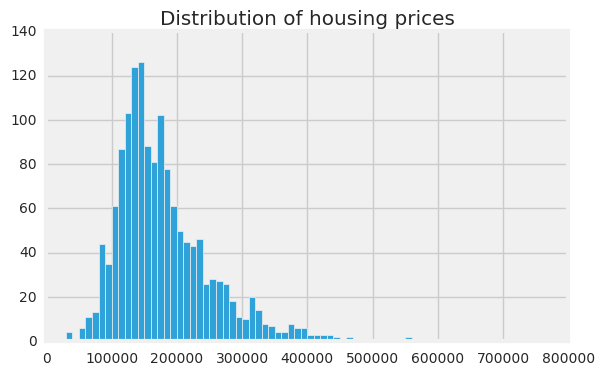

Very skewed looks like it needs some form of log transformation


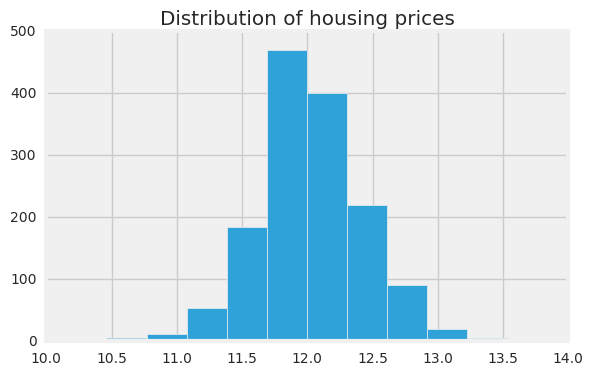

In [208]:
#What does the distribution of prices look like?
print(quant_df.price.describe())
plt.hist(quant_df.price, bins = np.arange(0, 800000, 10000))
plt.title('Distribution of housing prices')
plt.show()
print("Very skewed looks like it needs some form of log transformation")
plt.hist(np.log(quant_df.price))
plt.title('Distribution of housing prices')

Looks like log transforming prices might actually help us in dealing with all the skew in our data.

## Quality and Condition 

In [209]:
quant_df.price = np.log(quant_df.price)

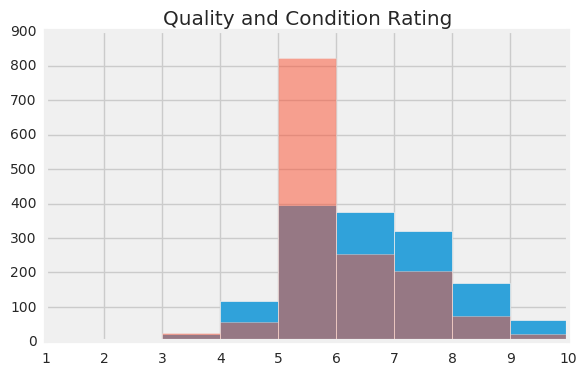

In [210]:
quant_df.quality_rating.hist(bins=np.arange(1,11))
quant_df.condition_rating.hist(bins=np.arange(1,11), alpha=0.5)
plt.title('Quality and Condition Rating')
plt.show()

This is a bit confusing. What is the difference between high quality rating and high conditioning rating?

Correlations:
Plot 1: -0.0368679877303
Plot 2: 0.817184417922
Plot 3: 0.64311723679


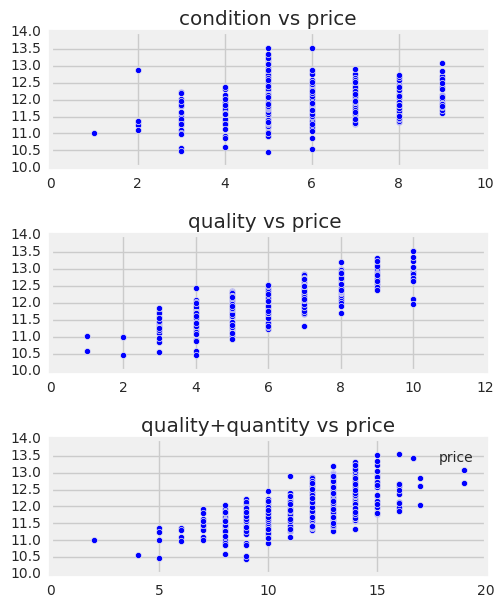

In [272]:
#Explore the relationship between quality rating, condition rating and price
f, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(quant_df.condition_rating, quant_df.price)
ax1.set_title('condition vs price')
ax2.scatter(quant_df.quality_rating, quant_df.price)
ax2.set_title('quality vs price ')
ax3.scatter(quant_df.quality_rating+quant_df.condition_rating, quant_df.price)
ax3.set_title('quality+quantity vs price')
f.subplots_adjust(hspace=0.5)
f.set_size_inches(5,7)
plt.legend()
print("Correlations:")
print("Plot 1:", np.corrcoef(quant_df.condition_rating, quant_df.price)[0,1])
print("Plot 2:", np.corrcoef(quant_df.quality_rating, quant_df.price)[0,1])
print("Plot 3:", np.corrcoef(quant_df.quality_rating+quant_df.condition_rating, quant_df.price)[0,1])

Looks like the quality score is actually a very informative feature and looks like we can even treat it as numerical instead of ordinal. Very high correlation 0.8 with log price. Condition does not seem to be that informative. 

## House Area

Another thing I want to look at is the total area of the property and how that relates to price. (Granted there are gonna be differences but it is worth seeing the variation)

I think that the total area of the house is:

                    total_area = garage + above_ground_area + basement

In [352]:
from sklearn.preprocessing import StandardScaler

Correlation 0.833558831574


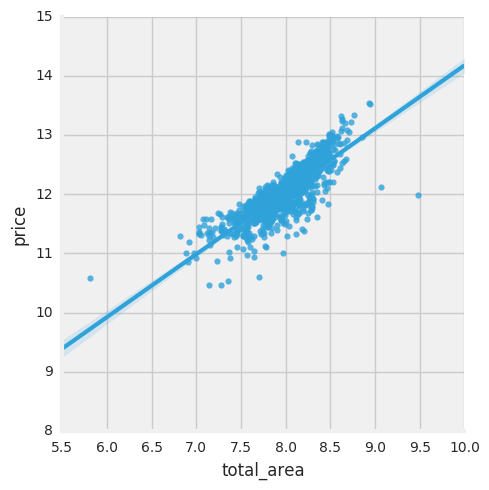

In [356]:
total_area = quant_df.above_ground_area+quant_df.total_basement_area+quant_df.garage_area
quant_df['total_area'] =  np.log(total_area)
sns.lmplot(data=quant_df, x='total_area',y='price', line_kws={'linewidth':3})
print('Correlation', np.corrcoef(np.log(total_area), quant_df.price)[0,1])

In [336]:
#perhaps the pool thing would be more useful as a binary feature like has_pool since it is super sparse

In [359]:
#seeing elastic net performing well from what we see